In [1]:
import numpy as np 
import pandas as pd 
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

import matplotlib.pyplot as plt
import seaborn as sns

plot_params = dict(
    color="0.75",
    marker="o",
    markeredgecolor="0.25")

In [2]:
stores = pd.read_csv('/kaggle/input/walmart-recruiting-store-sales-forecasting/stores.csv')
print(stores.shape)
stores.head()

(45, 3)


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [3]:
stores.describe(include='all')

,Store,Type,Size
count,45.000000,45,45.000000
unique,NaN,3,NaN
top,NaN,A,NaN
freq,NaN,22,NaN
mean,23.000000,NaN,130287.600000
std,13.133926,NaN,63825.271991
min,1.000000,NaN,34875.000000
25%,12.000000,NaN,70713.000000
50%,23.000000,NaN,126512.000000
75%,34.000000,NaN,202307.000000


In [4]:
features = pd.read_csv('/kaggle/input/walmart-recruiting-store-sales-forecasting/features.csv.zip', parse_dates=['Date'])
print(features.shape)
features.head()

(8190, 12)


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [5]:
features.describe(include='all')

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
count,8190.000000,8190,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000,8190
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7605
mean,23.000000,2011-10-31 12:00:00,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821,NaN
min,1.000000,2010-02-05 00:00:00,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000,NaN
25%,12.000000,2010-12-17 00:00:00,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000,NaN
50%,23.000000,2011-10-31 12:00:00,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000,NaN
75%,34.000000,2012-09-14 00:00:00,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000,NaN
max,45.000000,2013-07-26 00:00:00,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000,NaN


In [6]:
test = pd.read_csv('/kaggle/input/walmart-recruiting-store-sales-forecasting/test.csv.zip',  parse_dates=['Date'])
train = pd.read_csv('/kaggle/input/walmart-recruiting-store-sales-forecasting/train.csv.zip', parse_dates=['Date'])
print(train.shape)
train.head()

(421570, 5)


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [7]:
train.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False
421569,45,98,2012-10-26,1076.80,False


In [8]:
train.describe()

,Store,Dept,Date,Weekly_Sales
count,421570.000000,421570.000000,421570,421570.000000
mean,22.200546,44.260317,2011-06-18 08:30:31.963375104,15981.258123
min,1.000000,1.000000,2010-02-05 00:00:00,-4988.940000
25%,11.000000,18.000000,2010-10-08 00:00:00,2079.650000
50%,22.000000,37.000000,2011-06-17 00:00:00,7612.030000
75%,33.000000,74.000000,2012-02-24 00:00:00,20205.852500
max,45.000000,99.000000,2012-10-26 00:00:00,693099.360000
std,12.785297,30.492054,NaN,22711.183519


# Playground

In [9]:
#Make df with store 1 dep 1 only data
store = train[(train['Store'] == 1) & (train['Dept'] == 1)]
store = store.set_index(keys=store.Date)
store.drop(columns=['Store', 'Dept', 'Date'], inplace=True)
store.to_period()
store.head()

,Weekly_Sales,IsHoliday
Date,,
2010-02-05,24924.50,False
2010-02-12,46039.49,True
2010-02-19,41595.55,False
2010-02-26,19403.54,False
2010-03-05,21827.90,False


In [10]:
#add time-step and lag features
store['Time'] = np.arange(len(store.index))
store['Lag_1'] = store['Weekly_Sales'].shift(1)
store.head()

,Weekly_Sales,IsHoliday,Time,Lag_1
Date,,,,
2010-02-05,24924.50,False,0,NaN
2010-02-12,46039.49,True,1,24924.50
2010-02-19,41595.55,False,2,46039.49
2010-02-26,19403.54,False,3,41595.55
2010-03-05,21827.90,False,4,19403.54


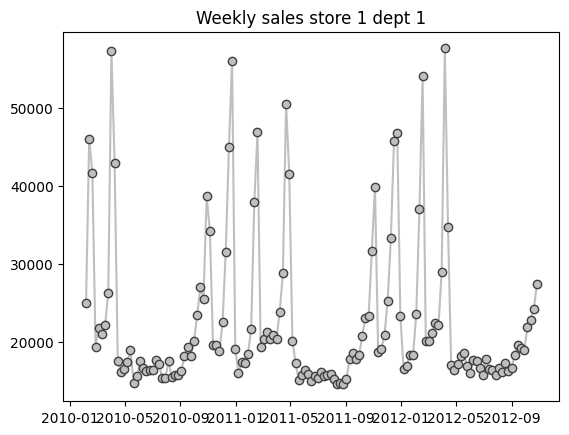

In [11]:
plt.plot(store.index, store.Weekly_Sales, **plot_params)
plt.title('Weekly sales store 1 dept 1')
#sns.regplot(x='Time', y='Weekly_Sales', data=store, ci=None, scatter_kws=dict(color='0.25'))
plt.show()


Text(0.5, 1.0, 'Lag Plot of Weekly Sales')

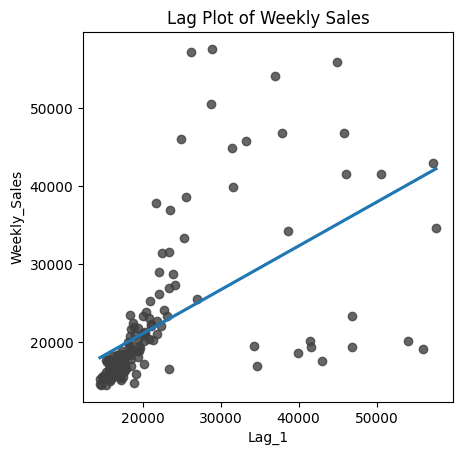

In [12]:
ax = sns.regplot(x='Lag_1', y='Weekly_Sales', data=store, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Weekly Sales')

In [13]:
#make prediction with Linear regression and lag feature
X = store.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = store['Weekly_Sales']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

In [14]:
y_pred.head()

Date
2010-02-12    23871.299047
2010-02-19    35742.852338
2010-02-26    33244.320701
2010-03-05    20767.230759
2010-03-12    22130.287002
dtype: float64

<Axes: xlabel='Date'>

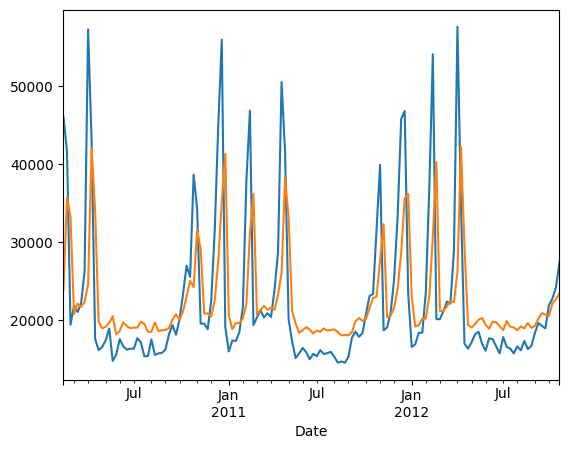

In [15]:
# plot_params = dict(
#     color="0.75",
#     style=".-",
#     markeredgecolor="0.25",
#     markerfacecolor="0.25",
#     legend=False,
# )
y.plot()
y_pred.plot()

## Trend

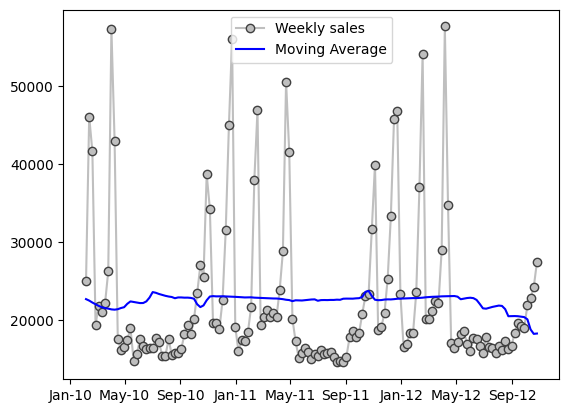

In [16]:
#Looking at trend using moving average
#store.to_period()

moving_average = store.rolling(
    window=52,         # 1 year window
    center=True,      # puts the average at the center of the window
    min_periods=26,    # choose half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%b-%y')

ax = plt.subplot()
ax.plot(store.index, store.Weekly_Sales, **plot_params, label='Weekly sales')
ax.xaxis.set_major_formatter(myFmt)
ax.plot(moving_average.index, moving_average['Weekly_Sales'], label='Moving Average', color='blue')
plt.legend()
plt.show()

I think I don't have anough data to identify a trend, however for the sake of this excercise I will create a trend feature and then fit a model.

In [17]:
#Create a trend feature
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=store.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
trend = dp.in_sample()

trend.head()

,const,trend
Date,,
2010-02-05,1.0,1.0
2010-02-12,1.0,2.0
2010-02-19,1.0,3.0
2010-02-26,1.0,4.0
2010-03-05,1.0,5.0


In [18]:
#Create trend model
y = store['Weekly_Sales']  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(trend, y)

y_pred = pd.Series(model.predict(trend), index=trend.index)

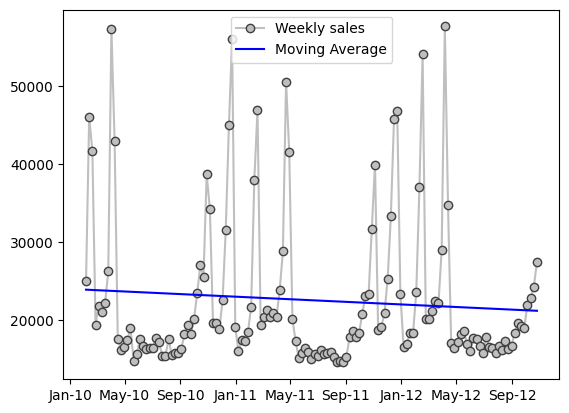

In [19]:
#Plot trend calculated with LinearRegression
ax = plt.subplot()
ax.plot(store.index, store.Weekly_Sales, **plot_params, label='Weekly sales')
ax.xaxis.set_major_formatter(myFmt)
ax.plot(y_pred, label='Moving Average', color='blue')
plt.legend()
plt.show()

In [20]:
#Make forecast
n_weeks = 30
forecast_index = pd.date_range(start=store.index[-1], periods=n_weeks, freq='W')
X = dp.out_of_sample(steps=n_weeks, forecast_index=forecast_index)
y_fore = pd.Series(model.predict(X), index=X.index)
y_fore.head()

2012-10-28    21141.494071
2012-11-04    21122.440892
2012-11-11    21103.387713
2012-11-18    21084.334535
2012-11-25    21065.281356
Freq: W-SUN, dtype: float64

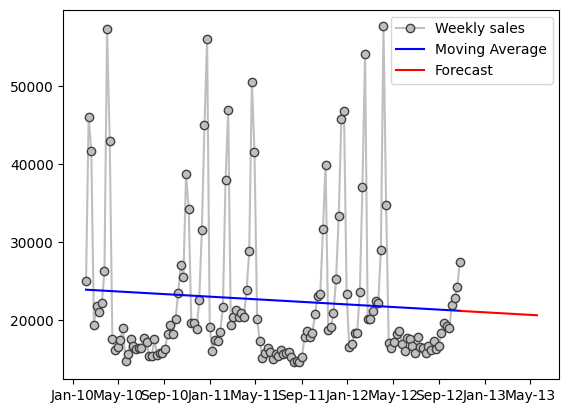

In [21]:
#Plot forecast
ax = plt.subplot()
ax.plot(store.index, store.Weekly_Sales, **plot_params, label='Weekly sales')
ax.xaxis.set_major_formatter(myFmt)
ax.plot(y_pred, label='Moving Average', color='blue')
ax.plot(y_fore, label='Forecast', color='red')
ax.plot()
plt.legend()
plt.show()

## Seasonality

Let's take a look at seasonal plots over a year.

In [22]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

<Axes: title={'center': 'Seasonal Plot (year/day_of_year)'}, xlabel='day_of_year', ylabel='Weekly_Sales'>

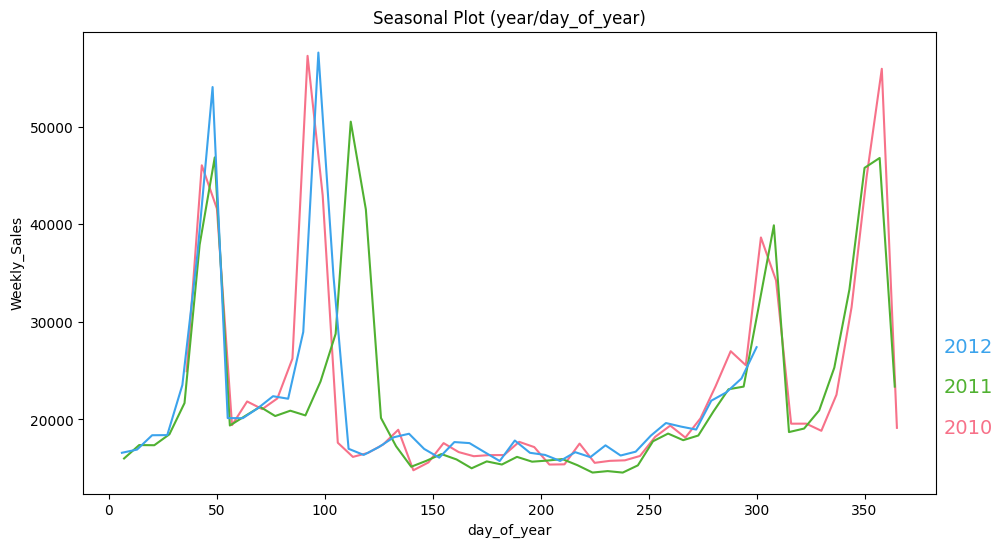

In [23]:
X = store.copy().drop(columns=['IsHoliday', 'Time', 'Lag_1'])

# weeks within a year
X["day_of_year"] = X.index.day_of_year  # the x-axis (freq)
X["year"] = X.index.year  # the seasonal period (period)

fig, ax0 = plt.subplots(1, 1, figsize=(11, 6))
seasonal_plot(X, y="Weekly_Sales", period="year", freq="day_of_year", ax=ax0)

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

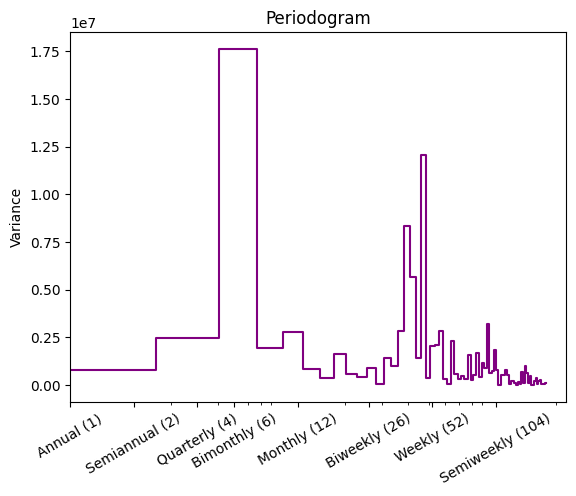

In [24]:
plot_periodogram(store.Weekly_Sales)

In [25]:
fourier = CalendarFourier(freq='M', order=52)  #the periodogram falls between bimonthly and monthly, so 10 fourier pairs 
dp = DeterministicProcess(
    index=store.index,
    constant=True,
    order=1,
    seasonal=False,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X.head()

,const,trend,"sin(1,freq=M)","sin(2,freq=M)","sin(4,freq=M)","cos(4,freq=M)","cos(5,freq=M)","sin(6,freq=M)","sin(7,freq=M)","cos(7,freq=M)",...,"sin(46,freq=M)","cos(47,freq=M)","sin(48,freq=M)","cos(48,freq=M)","sin(49,freq=M)","sin(50,freq=M)","cos(50,freq=M)","sin(51,freq=M)","cos(51,freq=M)","cos(52,freq=M)"
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1.0,1.0,0.781831,0.974928,-0.433884,-0.900969,-0.222521,-0.781831,-2.449294e-16,1.000000e+00,...,-0.433884,-0.222521,-0.781831,0.623490,-1.714506e-15,0.781831,0.623490,0.974928,-0.222521,-0.900969
2010-02-12,1.0,2.0,0.623490,-0.974928,-0.433884,-0.900969,0.974928,0.781831,-1.000000e+00,-2.449913e-15,...,0.433884,-0.974928,-0.781831,0.623490,1.000000e+00,-0.781831,-0.623490,0.222521,0.974928,-0.900969
2010-02-19,1.0,3.0,-0.781831,0.974928,-0.433884,-0.900969,0.222521,-0.781831,1.102182e-15,-1.000000e+00,...,-0.433884,0.222521,-0.781831,0.623490,-2.942866e-15,0.781831,0.623490,-0.974928,0.222521,-0.900969
2010-02-26,1.0,4.0,-0.623490,-0.974928,-0.433884,-0.900969,-0.974928,0.781831,1.000000e+00,-2.455483e-16,...,0.433884,0.974928,-0.781831,0.623490,-1.000000e+00,-0.781831,-0.623490,-0.222521,-0.974928,-0.900969
2010-03-05,1.0,5.0,0.724793,0.998717,-0.101168,-0.994869,-0.612106,-0.988468,-5.712682e-01,8.207634e-01,...,-0.394356,0.918958,0.937752,0.347305,8.978045e-01,0.299363,-0.954139,-0.485302,-0.874347,-0.250653


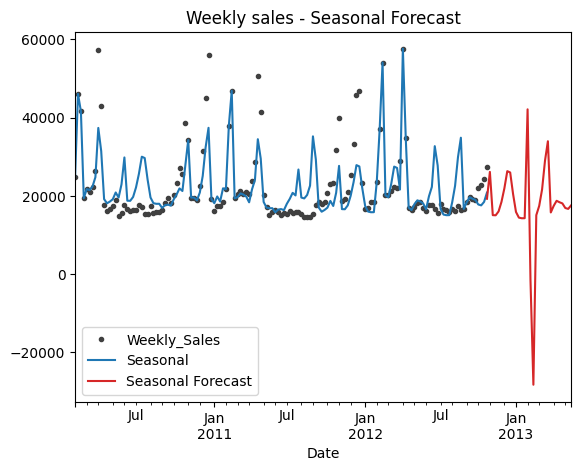

In [26]:
y = store['Weekly_Sales']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)  #convert array into df

n_weeks = 30
forecast_index = pd.date_range(start=store.index[-1], periods=n_weeks, freq='W')
X_fore = dp.out_of_sample(steps=n_weeks, forecast_index=forecast_index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Weekly sales - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
ax.legend()

## Cycles

In [27]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

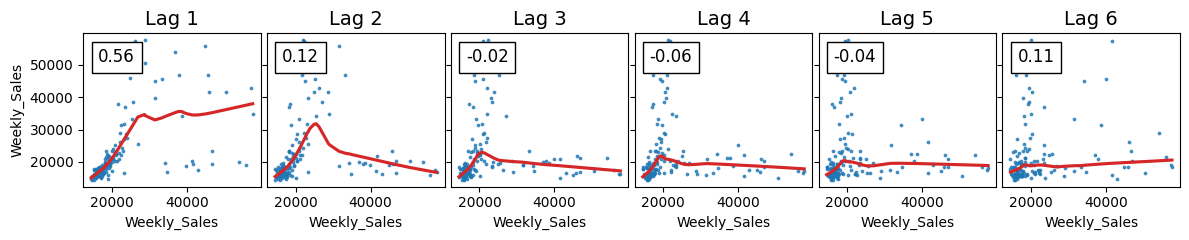

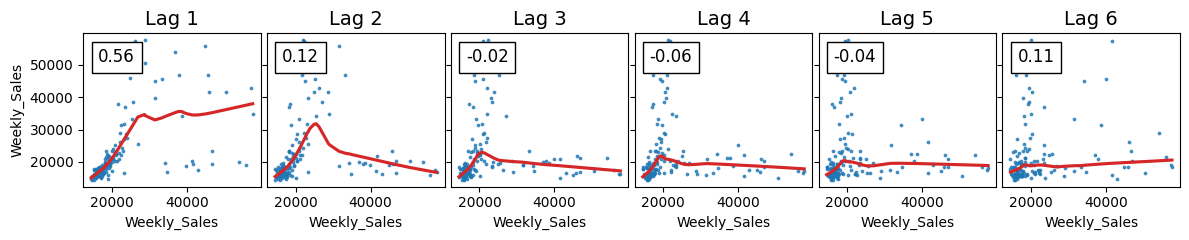

In [28]:
plot_lags(store.Weekly_Sales, lags=6)

In [29]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X = make_lags(store.Weekly_Sales, lags=2)
X = X.fillna(0.0)

In [30]:
# Create target series and data splits
y = store.Weekly_Sales.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

<Axes: xlabel='Date'>

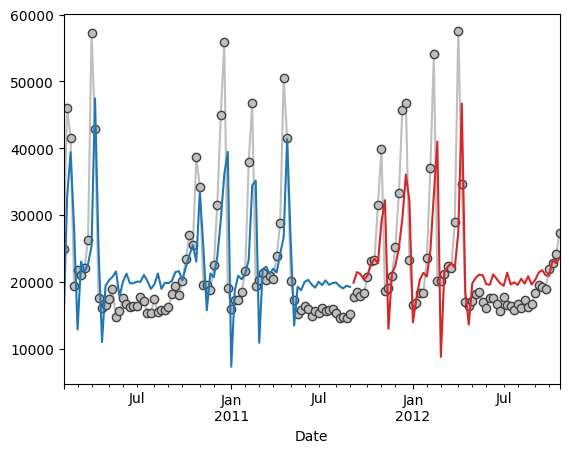

In [31]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
y_fore.plot(ax=ax, color='C3')

## Hybrid model for prediction

Use linear regression to extrapolate the trend, transform the target to remove the trend, and apply XGBoost to the detrended residuals (boosted hybrid).

In [32]:
store.head()

,Weekly_Sales,IsHoliday,Time,Lag_1
Date,,,,
2010-02-05,24924.50,False,0,NaN
2010-02-12,46039.49,True,1,24924.50
2010-02-19,41595.55,False,2,46039.49
2010-02-26,19403.54,False,3,41595.55
2010-03-05,21827.90,False,4,19403.54


In [33]:
y = store.drop(columns=['IsHoliday', 'Time', 'Lag_1'])
y.head()

,Weekly_Sales
Date,
2010-02-05,24924.50
2010-02-12,46039.49
2010-02-19,41595.55
2010-02-26,19403.54
2010-03-05,21827.90


Text(0.5, 1.0, 'Trends')

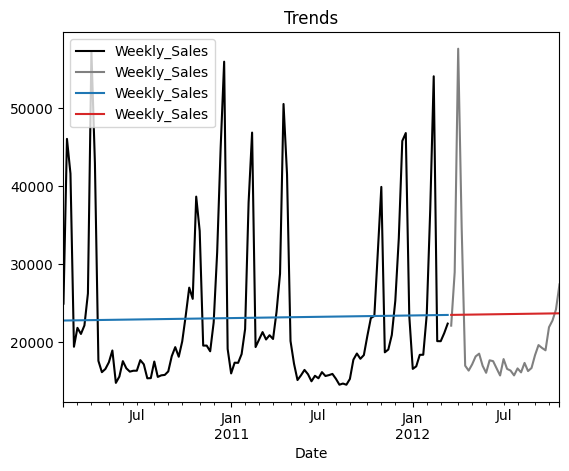

In [34]:
# Create trend feature
dp = DeterministicProcess(
        index = y.index,     #dates from the training data
        constant = True,     #the intercept
        order = 1,           #linear trend
        drop = True)         #drop terms to avoid colinearity

X = dp.in_sample()

#Test on 8 months (=32 weeks). It will be easier for later to split on the index
idx_train, idx_test = train_test_split(
        y.index, 
        test_size=8*4, 
        shuffle=False, 
        random_state=1
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

#Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

#Make predictions
y_fit = pd.DataFrame(
        model.predict(X_train),
        index=y_train.index,
        columns=y_train.columns
)

y_pred = pd.DataFrame(
        model.predict(X_test),
        index=y_test.index,
        columns=y_test.columns
)

# Plot
axs = y_train.plot(color='Black', label='Train')
axs = y_test.plot(color='Gray', ax=axs, label='Test')
axs = y_fit.plot(color='C0', ax=axs, label='Trend train')
axs = y_pred.plot(color='C3', ax=axs, label='Trend test')
plt.legend()
plt.title("Trends")

In [35]:
# Add column with months (we already have y)
X = y.drop(columns=['Weekly_Sales'])
X['Month'] = X.index.month


#Create split
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

In [36]:
y_fit.head()

,Weekly_Sales
Date,
2010-02-05,22763.139630
2010-02-12,22769.642441
2010-02-19,22776.145252
2010-02-26,22782.648063
2010-03-05,22789.150874


In [37]:
#Convert df to series (squeeze)
y_fit = y_fit.squeeze()
y_pred = y_pred.squeeze()
y_train = y_train.squeeze()

#Create residuals (collection of detrended series) from the train set
y_resid = y_train - y_fit

#Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

Text(0.5, 1.0, 'Trends')

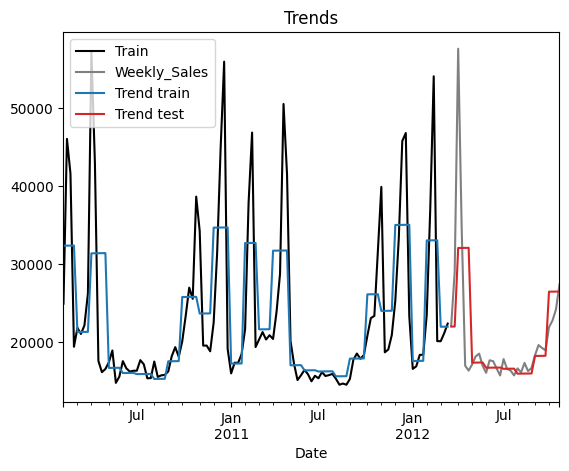

In [38]:
# Plot
axs = y_train.plot(color='Black', label='Train')
axs = y_test.plot(color='Gray', ax=axs, label='Test')
axs = y_fit_boosted.plot(color='C0', ax=axs, label='Trend train')
axs = y_pred_boosted.plot(color='C3', ax=axs, label='Trend test')
plt.legend()
plt.title("Trends")

In [39]:
xgb.score(X_test, y_pred_boosted)

-17.239405960920337

## Seasonal-Trend decomposition using LOESS (STL)
https://www.statsmodels.org/devel/examples/notebooks/generated/stl_decomposition.html

This note book illustrates the use of STL to decompose a time series into three components: trend, season(al) and residual. STL uses LOESS (locally estimated scatterplot smoothing) to extract smooths estimates of the three components. The key inputs into STL are:

- `season` - The length of the seasonal smoother. Must be odd.
- `trend` - The length of the trend smoother, usually around 150% of season. Must be odd and larger than season.
- `low_pass` - The length of the low-pass estimation window, usually the smallest odd number larger than the periodicity of the data.

The decomposition requires 1 input, the data series. If the data series does not have a frequency, then you must also specify period. The default value for seasonal is 7, and so should also be changed in most applications.

In [40]:
# 1,5 * period /(1-1.5/seasonal)

f = 1 - 1.5 / 3
1.5 * 52 / f

156.0

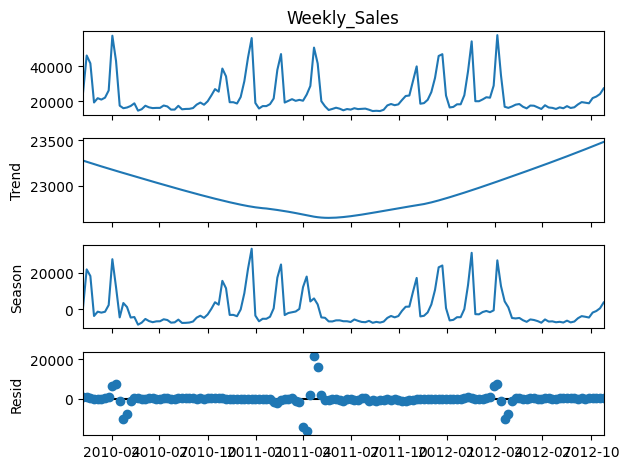

In [41]:
from statsmodels.tsa.seasonal import STL

stl = STL(store.Weekly_Sales)
res = stl.fit()
fig = res.plot()

Check here for residual diagnostic:

https://otexts.com/fpp3/diagnostics.html

## ARIMA model

https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

In [42]:
import statsmodels.api as sm
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

! pip install pmdarima
#from pmdarima  import arima
import pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.3 MB/s eta 0:00:00


In [43]:
from sklearn.metrics import mean_absolute_error

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))

In [44]:
train = pd.read_csv('/kaggle/input/walmart-recruiting-store-sales-forecasting/train.csv.zip', parse_dates=['Date'])
store = train[(train['Store'] == 1) & (train['Dept'] == 1)]
store = store.set_index(keys=store.Date)
store.drop(columns=['Store', 'Dept', 'Date', 'IsHoliday'], inplace=True)
#store.to_period()
store.head()

,Weekly_Sales
Date,
2010-02-05,24924.50
2010-02-12,46039.49
2010-02-19,41595.55
2010-02-26,19403.54
2010-03-05,21827.90


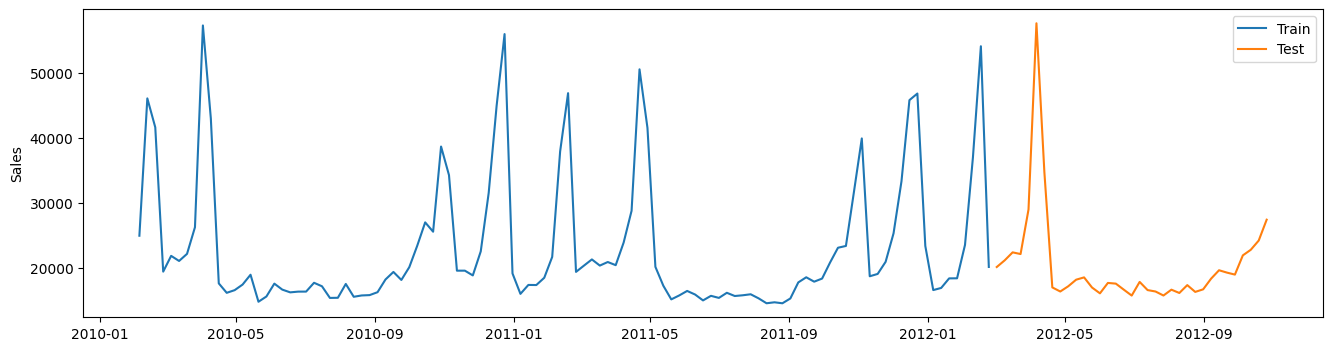

In [45]:
#Split train test data for ARIMA
train = store.iloc[:-int(len(store) * 0.25)]
test = store.iloc[-int(len(store) * 0.25):]

plt.figure(figsize=(16,4))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.ylabel('Sales')
plt.legend()

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


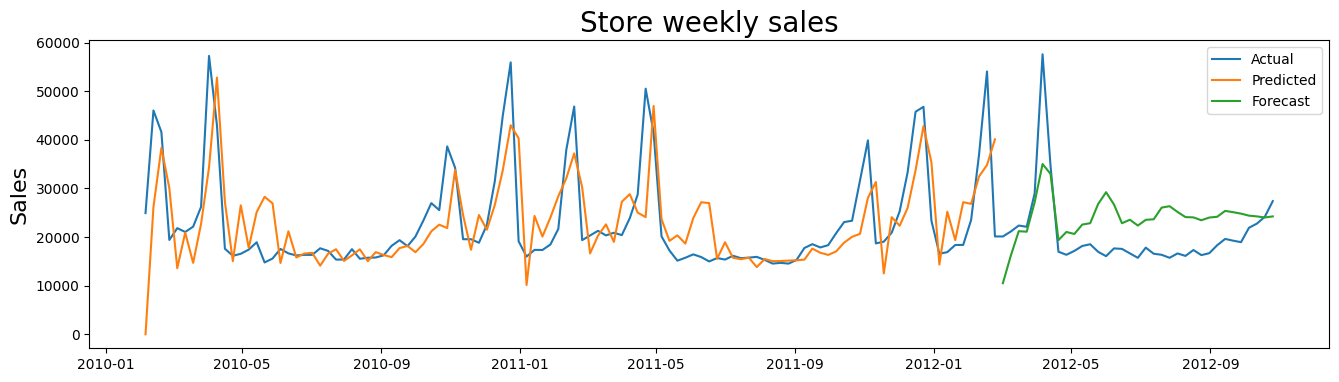

In [46]:
#ARIMA
arima = ARIMA(train['Weekly_Sales'], order=(12,1,1))
mod = arima.fit()
predictions = mod.predict()
forecast = mod.forecast(len(test))

plt.figure(figsize=(16,4))
plt.plot(store, label="Actual")
plt.plot(predictions, label="Predicted")
plt.plot(forecast, label='Forecast')
plt.title('Store weekly sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.legend()

In [47]:
mean_absolute_scaled_error(test.Weekly_Sales, forecast, train.Weekly_Sales)

1.12076252163701

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.75398D+00    |proj g|=  3.37530D-01

At iterate    5    f=  5.27100D+00    |proj g|=  5.78941D-03

At iterate   10    f=  5.25714D+00    |proj g|=  3.79373D-02

At iterate   15    f=  5.25185D+00    |proj g|=  8.75360D-03

At iterate   20    f=  5.24568D+00    |proj g|=  1.32498D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     42      1     0     0   1.979D-05   5.246D+00
  F =   5.2456165844880847     

CONVERG

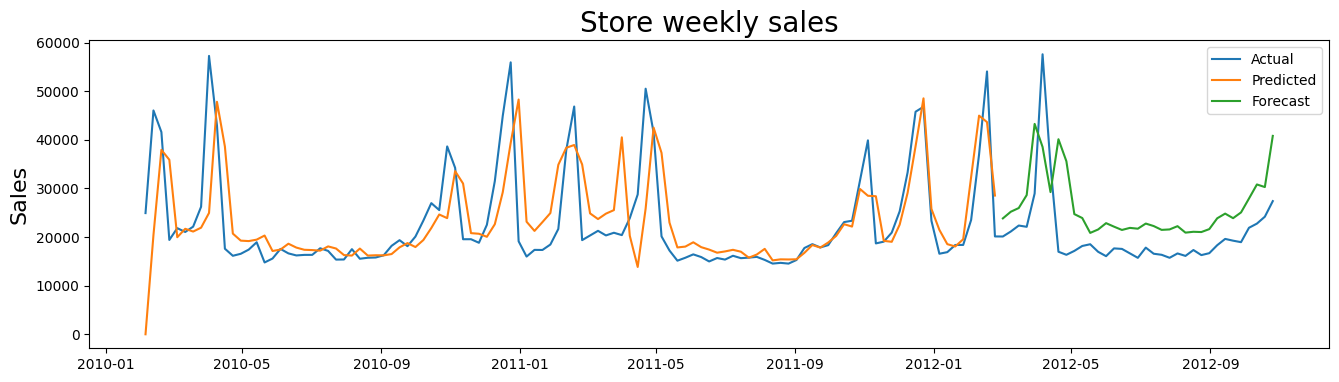

In [48]:
#SARIMA
sarima = SARIMAX(train['Weekly_Sales'],
                order=(1,1,1),                      #remove seasonal component from the ARIMA, so all parameters are 1
                seasonal_order=(1,1,0,52)).fit()   #m=12 is the number of observations per year

predictions = sarima.predict()
forecast = sarima.forecast(len(test))

plt.figure(figsize=(16,4))
plt.plot(store, label="Actual")
plt.plot(predictions, label="Predicted")
plt.plot(forecast, label='Forecast')
plt.title('Store weekly sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.legend()

In [49]:
mean_absolute_scaled_error(test.Weekly_Sales, forecast, train.Weekly_Sales)

1.2869395674801016

In [50]:
#Auto ARIMA
arima = pmdarima.arima.auto_arima(train['Weekly_Sales'], 
                        start_p=0, d=1, start_q=0,
                        max_p=5, max_d=5, max_q=5, 
                        start_P=0, D=1, start_Q=0, 
                        max_P=5, max_D=5, max_Q=5,
                        m=52, seasonal=True, 
                        error_action='warn', 
                        trace=True, 
                        suppress_warnings=True,
                        stepwise=True,
                        random_state=20, 
                        n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1158.141, Time=0.36 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=1145.661, Time=2.69 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=1144.058, Time=6.07 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=1158.561, Time=0.40 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=1147.755, Time=5.29 sec
 ARIMA(0,1,1)(0,1,2)[52]             : AIC=1148.026, Time=8.25 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=1145.777, Time=3.09 sec
 ARIMA(0,1,1)(1,1,2)[52]             : AIC=1149.755, Time=18.45 sec
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=1145.039, Time=2.38 sec
 ARIMA(1,1,1)(0,1,1)[52]             : AIC=1142.679, Time=8.59 sec
 ARIMA(1,1,1)(0,1,0)[52]             : AIC=1154.573, Time=1.14 sec
 ARIMA(1,1,1)(1,1,1)[52]             : AIC=1143.053, Time=10.52 sec
 ARIMA(1,1,1)(0,1,2)[52]             : AIC=1143.282, Time=27.18 sec
 ARIMA(1,1,1)(1,1,0)[52]             : AIC=1141.053, Time=9.96 sec
 ARIMA(1,1,1)(2,

In [51]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  108
Model:             SARIMAX(2, 1, 2)x(1, 1, [], 52)   Log Likelihood                -561.098
Date:                             Mon, 11 Dec 2023   AIC                           1134.196
Time:                                     16:18:07   BIC                           1146.240
Sample:                                 02-05-2010   HQIC                          1138.854
                                      - 02-24-2012                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7500      0.384      1.955      0.051      -0.002       1.502
ar.L2         -0.4725      0.310     -1.526      0.127      -1.079       0.134
ma.L1         -0.8456      0.471     -1.795      0.073      -1.769       0.078
ma.L2          0.1354      0.418      0.324      0.746      -0.684       0.955
ar.S.L52      -0.4238      0.065     -6.486      0.000      -0.552      -0.296
sigma2      4.301e+07   2.78e-08   1.55e+15      0.000     4.3e+07     4.3e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                24.49
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                             0.16
Prob(H) (two-sided):                  0.09   Kurtosis:                         6.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.17e+31. Standard errors may be unstable.
"""

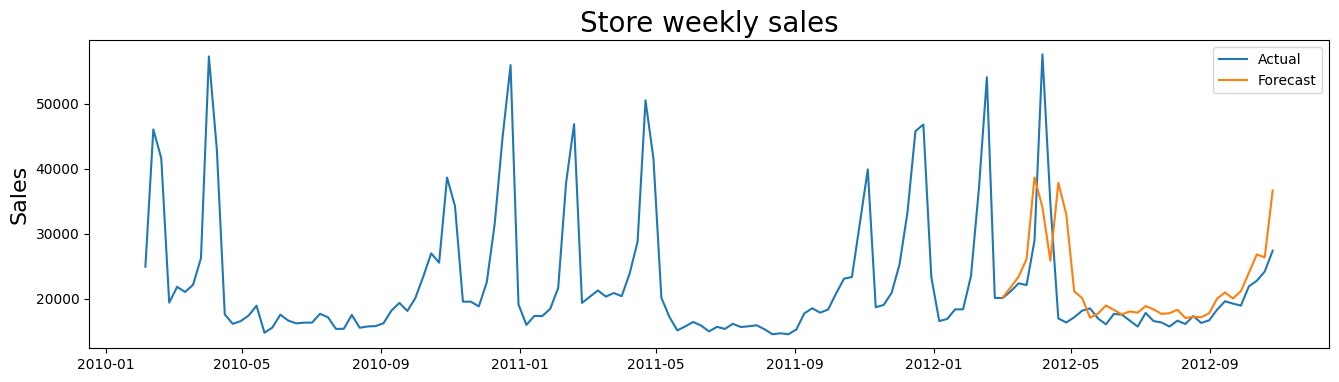

In [52]:
forecast = pd.DataFrame(arima.predict(n_periods=len(test)), index=test.index, columns=['Weekly_Sales'])

plt.figure(figsize=(16,4))
plt.plot(store, label="Actual")
#plt.plot(predictions, label="Predicted")
plt.plot(forecast, label='Forecast')
plt.title('Store weekly sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.legend()

In [53]:
mean_absolute_scaled_error(test.Weekly_Sales, forecast.Weekly_Sales, train.Weekly_Sales)

0.7059008370660796

In [54]:
#Auto ARIMA
arima = pmdarima.arima.auto_arima(train['Weekly_Sales'], 
                        start_p=0, d=1, start_q=0,
                        max_p=2, max_d=2, max_q=2, 
                        start_P=0, D=1, start_Q=0, 
                        max_P=2, max_D=2, max_Q=2,
                        m=52, seasonal=True, 
                        error_action='warn', 
                        trace=True, 
                        suppress_warnings=True,
                        stepwise=True,
                        random_state=20, 
                        n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1158.141, Time=0.34 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=1145.661, Time=2.45 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=1144.058, Time=6.18 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=1158.561, Time=0.30 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=1147.755, Time=4.15 sec
 ARIMA(0,1,1)(0,1,2)[52]             : AIC=1148.026, Time=8.05 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=1145.777, Time=3.05 sec
 ARIMA(0,1,1)(1,1,2)[52]             : AIC=1149.755, Time=18.42 sec
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=1145.039, Time=2.40 sec
 ARIMA(1,1,1)(0,1,1)[52]             : AIC=1142.679, Time=8.79 sec
 ARIMA(1,1,1)(0,1,0)[52]             : AIC=1154.573, Time=1.10 sec
 ARIMA(1,1,1)(1,1,1)[52]             : AIC=1143.053, Time=11.81 sec
 ARIMA(1,1,1)(0,1,2)[52]             : AIC=1143.282, Time=25.60 sec
 ARIMA(1,1,1)(1,1,0)[52]             : AIC=1141.053, Time=11.11 sec
 ARIMA(1,1,1)(2